Coupling map:


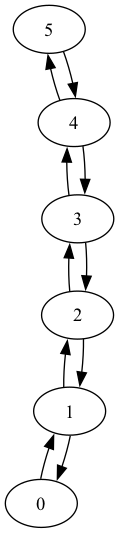

In [2]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt
from rl_qoc.helpers.transpiler_passes import CausalConePass

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

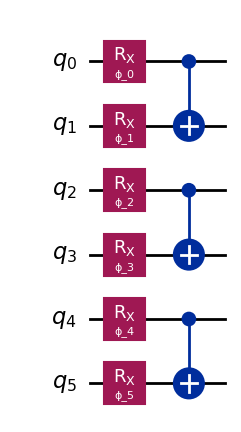

In [3]:
circuit = circuit_context(num_qubits, rotation_axes, rotation_parameters, coupling_map=cm)
circuit.draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

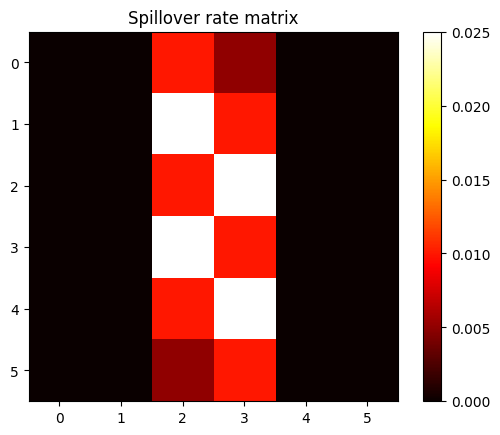

In [4]:
# Define noise-coupling matrix with gamma values (example values)
# gamma_matrix = np.zeros((num_qubits, num_qubits))
# gamma_matrix[0, 1] = 0.0  # γ_0->1
# gamma_matrix[0, 3] = 0.0  # γ_0->3
# gamma_matrix[1, 2] = 0.0  # γ_1->2
# gamma_matrix[2, 2] = 0.0  # γ_2->2
# gamma_matrix[2, 3] = 0.05  # γ_2->3
# gamma_matrix[3, 2] = 0.05  # γ_3->2
# gamma_matrix[4, 3] = 0.0  # γ_4->3
# gamma_matrix[5, 4] = 0.0  # γ_5->4
# # gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)
#
# # Generate another gamma matrix based on coupling map defined above
# gamma_matrix = 0.01 * np.eye(num_qubits)
# for edge in cm.get_edges():
#     gamma_matrix[edge[0], edge[1]] = 0.05
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 3] = 0.005  # γ_0->3
gamma_matrix[1, 3] = 0.01  # γ_1->3
gamma_matrix[2, 3] = 0.025  # γ_2->3
gamma_matrix[3, 3] = 0.01  # γ_2->3
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 3] = 0.01  # γ_5->3
gamma_matrix[0, 2] = 0.01  # γ_0->2
gamma_matrix[1, 2] = 0.025  # γ_1->2
gamma_matrix[2, 2] = 0.01  # γ_1->2
gamma_matrix[3, 2] = 0.025  # γ_3->2
gamma_matrix[4, 2] = 0.01  # γ_4->2
gamma_matrix[5, 2] = 0.005  # γ_5->2

# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [5]:
from qiskit import QuantumRegister
# Add here custom ansatz CX gate

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{target.gate.name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        new_params[0],
        -0.5 * np.pi,
        0.5 * np.pi,
        q_reg[0],
    )
    my_qc.u(
        0,
        new_params[1],
        new_params[2],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])


    qc.append(my_qc.to_gate(label=my_qc.name), q_reg)

In [6]:
# Define the environment
from gymnasium.spaces import Box
from gymnasium.wrappers import RescaleObservation, FlattenObservation
from rl_qoc.environment.wrappers import ContextSamplingWrapper
from spillover_context_wrapper import SpilloverContextSamplingWrapper, SpilloverConfig
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
    GateTarget, BenchmarkConfig,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)
from qiskit.transpiler import Layout, generate_preset_pass_manager
from qiskit_aer import AerSimulator

seed = 20983
# Select the target subsystem used for the calibration
target_subsystem = (2, 3)
spillover_pass = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=target_subsystem,
)
causal_cone_pass = CausalConePass(target_subsystem) 

full_pm = generate_preset_pass_manager(optimization_level=0, backend=AerSimulator())
custom_translation_pass = PassManager(
    [spillover_pass, causal_cone_pass])
custom_translation_pass.append(full_pm.translation.to_flow_controller().passes)
full_pm.translation = custom_translation_pass
action_space = Box(low=-0.3, high=0.3, shape=(7,), dtype=np.float32)
target = GateTarget(
    physical_qubits=target_subsystem,
    gate="cx",
    circuit_context=circuit,
    virtual_target_qubits=target_subsystem,
    layout=Layout.generate_trivial_layout(*circuit.qregs),
)

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[10],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="channel",
    benchmark_config=BenchmarkConfig(1)
)

spillover_config = SpilloverConfig(gamma_matrix, target_subsystem,)
q_env = ArbitraryAngleSpilloverEnv(
    q_env_config
)
q_env = SpilloverContextSamplingWrapper(q_env, spillover_config, {})

In [7]:
print(q_env.observation_space)

Dict('ϕ_0': Box(0.0, 3.1415927, (1,), float32), 'ϕ_1': Box(0.0, 3.1415927, (1,), float32), 'ϕ_2': Box(0.0, 3.1415927, (1,), float32), 'ϕ_3': Box(0.0, 3.1415927, (1,), float32), 'ϕ_4': Box(0.0, 3.1415927, (1,), float32), 'ϕ_5': Box(0.0, 3.1415927, (1,), float32))


In [8]:
from gymnasium.wrappers import RescaleObservation, FlattenObservation
q_env = RescaleObservation(FlattenObservation(q_env), -1., 1.)
print(q_env.observation_space)


Box(-1.0, 1.0, (6,), float32)


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [9]:
rescaled_env = RescaleAndClipAction(q_env, -1, 1)
u_env = rescaled_env.unwrapped

In [10]:
vals = np.pi *np.ones(7)

In [11]:
rescaled_env.reset(options={"parameters":{p.name: val for p, val in zip(circuit.parameters, vals)}})

(array([1., 1., 1., 1., 1., 1.], dtype=float32), {})

In [12]:
u_env._get_obs()

{'ϕ_0': 3.141592653589793,
 'ϕ_1': 3.141592653589793,
 'ϕ_2': 3.141592653589793,
 'ϕ_3': 3.141592653589793,
 'ϕ_4': 3.141592653589793,
 'ϕ_5': 3.141592653589793}

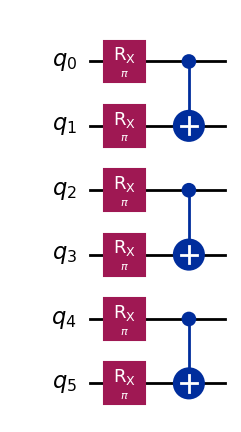

In [13]:
u_env.target.circuit.draw("mpl")

In [14]:
u_env.backend

AerSimulator('custom_spillover_impact_simulator'
             noise_model=<NoiseModel on ['rx(3.14, 0)', 'rx(3.14, 1)']>)

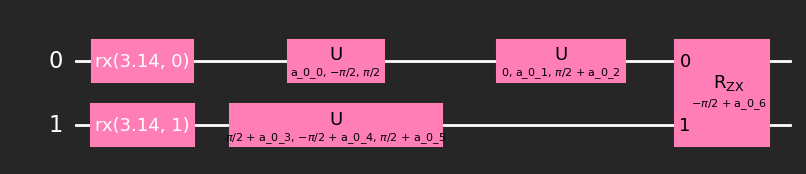

In [15]:
u_env.config.backend_config.custom_transpile(u_env.circuit, initial_layout=u_env.target.layout).draw(
    "mpl", style='iqp-dark'
)

Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9718971700835132
Reward (avg): 0.9718971700835132 Std: 0.0
Number of repetitions: 2
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9718971700835132
Reward (avg): 0.9181682457104161 Std: 0.0
Number of repetitions: 3
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9718971700835132
Reward (avg): 0.8200968698469465 Std: 0.0
Number of repetitions: 4
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9718971700835132
Reward (avg): 0.7140416209953336 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9718971700835132
Reward (avg): 0.5924790485698652 Std: 0.0
Number of repetitions: 6
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (

[[0.9718971700835132,
  0.9181682457104161,
  0.8200968698469465,
  0.7140416209953336,
  0.5924790485698652,
  0.4881152644149275,
  0.39779542291093856,
  0.34316270963678874,
  0.31669594283346986,
  0.32769881068630696,
  0.3589660820769317,
  0.4127368380052485,
  0.46342810713915306,
  0.5145699589937465,
  0.5393020533316826,
  0.5486796521105863,
  0.5231204973107736,
  0.48156865740130445,
  0.41652535068457885,
  0.349290327383527,
  0.2825820142632196,
  0.23230095695904057,
  0.20395334344369673,
  0.20314867430005545,
  0.22961862183221804,
  0.2799938658724311,
  0.3435688265596945,
  0.41502498869285853,
  0.47502400271332945,
  0.5249949767007511,
  0.543798603811596,
  0.5448183749378354,
  0.5124437604812966,
  0.4706178367351715,
  0.4122801867616765,
  0.3647947163829846,
  0.3262645807657562,
  0.3189307357750633,
  0.3381988059630633,
  0.39644404776196235,
  0.4788547400686941,
  0.5899125716361244,
  0.7021750046882644,
  0.8197532197787044,
  0.9070494361031287

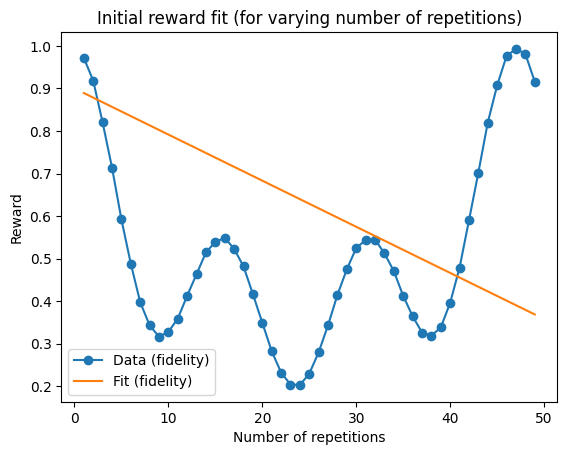

In [16]:
u_env.initial_reward_fit(
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=2000,
        n_shots=100,
        n_reps=list(
            range(1, 50),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="fidelity",
)

In [17]:
from rl_qoc.agent import PPOConfig

agent_config = PPOConfig.from_yaml("agent_config.yaml")
print(agent_config)

PPOConfig(run_name='spillover_subsystem', num_updates=1, n_epochs=8, learning_rate=0.0005, gamma=0.99, gae_lambda=0.95, clip_ratio=0.2, clip_value_loss=True, clip_value_coef=0.2, normalize_advantage=True, entropy_coef=0.01, value_loss_coef=0.5, gradient_clip=0.5, include_critic=True, hidden_layers=[64, 64], hidden_activation_functions=[Tanh(), Tanh()], input_activation_function=Identity(), output_activation_mean=Tanh(), output_activation_std=Sigmoid(), optimizer=<class 'torch.optim.adam.Adam'>, minibatch_size=16, checkpoint_dir='tmp/ppo', training_config=TrainingConfig(training_constraint=TotalUpdates(total_updates=250), target_fidelities=[0.999, 0.9999, 0.99999], lookback_window=10, anneal_learning_rate=False, std_actions_eps=0.01), train_function_settings=TrainFunctionSettings(plot_real_time=False, print_debug=False, num_prints=10, hpo_mode=False, clear_history=False, save_data=False), wandb_config=WandBConfig(enabled=False, project='GateCalibration', entity=None, tags=None, notes=No

In [18]:
from rl_qoc.agent import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_env)
total_updates = 2000
target_fidelities = [0.999]
lookback_window = 20
anneal_learning_rate = True

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)

In [19]:
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

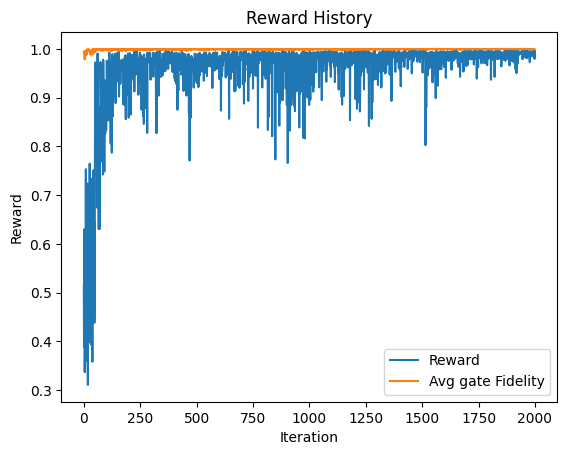

{'avg_reward': [0.5138447284340528,
  0.38899089221101024,
  0.40987463370692,
  0.6304644833296966,
  0.3370910992408134,
  0.42672285488949396,
  0.5667588734462906,
  0.4181273923500085,
  0.4006423025922471,
  0.753297091526284,
  0.40808609421016845,
  0.5361261659127505,
  0.36504277148194064,
  0.3607838033711178,
  0.5732311300570858,
  0.6122608239770333,
  0.724030749652703,
  0.36702272603274944,
  0.31094600155415814,
  0.6070244920627216,
  0.5499133953241141,
  0.593891487390926,
  0.4154266857316128,
  0.5860669031263325,
  0.40506627891416036,
  0.5943307736852467,
  0.7647547626494867,
  0.5185034149130178,
  0.562544786337684,
  0.3972651840689669,
  0.4038170152714611,
  0.6800940511211595,
  0.7334325064586511,
  0.5768513346769593,
  0.39280794691840526,
  0.6322966069661293,
  0.6931993163844583,
  0.4366442200986622,
  0.3586187956259674,
  0.535720472147478,
  0.5335400902418597,
  0.5496269159906338,
  0.7077498601339774,
  0.7512504745514335,
  0.6610265001706

<Figure size 640x480 with 0 Axes>

In [20]:
%matplotlib inline
ppo_agent.train(ppo_config, train_settings)

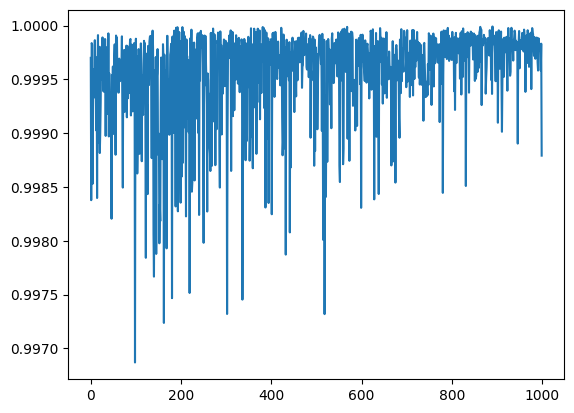

In [44]:
plt.plot(u_env.fidelity_history[1000:])

In [47]:
from torch import Tensor
from gate_level.spillover_noise_use_case.generic_spillover.arbitrary_angle_spillover_env import ArbitraryAngleSpilloverEnv
u_env: ArbitraryAngleSpilloverEnv

fidelity_history = []
baseline_history = []
n_angles = 1000
phi_array = np.zeros((n_angles, len(u_env.circuit_parameters)))
for i in range(n_angles):
    phi = np.random.uniform(0, np.pi, size=6)
    phi_array[i, :] = phi
    param_dict = {u_env.circuit_parameters[i].name: phi[i] for i in range(len(phi))}
    obs, _ = rescaled_env.reset(options={"parameters": param_dict})
    mu, sigma, critic = ppo_agent.agent(Tensor(obs))
    rescaled_action = rescaled_env.action(mu.detach().numpy())
    agent_fid = u_env.simulate_circuit(
        u_env.circuit.copy(),
        np.expand_dims(rescaled_action, 0),
        update_env_history=False,
    )
    fidelity_history.append(agent_fid)
    baseline_fid = u_env.simulate_circuit(
        u_env.circuit.copy(), np.zeros((1, 7)), update_env_history=False
    )
    baseline_history.append(baseline_fid)

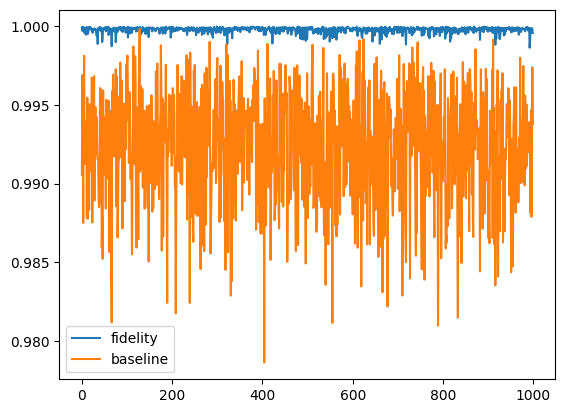

In [49]:
plt.plot(fidelity_history, label="fidelity")
plt.plot(baseline_history, label="baseline")
plt.legend()

In [50]:
for i in range(len(q_env.circuit_parameters)):
    plt.plot(phi_array[:, i] / (2 * np.pi), label=f"phi_{i}")

plt.legend()

AttributeError: 'RescaleObservation' object has no attribute 'circuit_parameters'

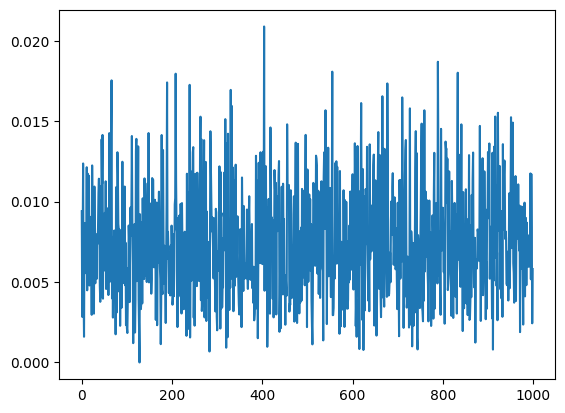

In [51]:
plt.plot(np.array(fidelity_history) - np.array(baseline_history))

In [52]:
print(
    "Percentage of under performance",
    len(np.where(np.array(fidelity_history) - np.array(baseline_history) < 0)[0]) * 100 / n_angles,
    "%",
)

Percentage of under performance 0.1 %


In [41]:
from qiskit.qasm3 import dumps as qasm3_dumps

print(
    qasm3_dumps(
        circuit_context(
            num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
        ).measure_all(False)
    )
)

OPENQASM 3.0;
include "stdgates.inc";
input float[64] ϕ_0;
input float[64] ϕ_1;
input float[64] ϕ_2;
input float[64] ϕ_3;
input float[64] ϕ_4;
input float[64] ϕ_5;
bit[6] meas;
qubit[6] q;
rx(ϕ_0) q[0];
rx(ϕ_1) q[1];
rx(ϕ_2) q[2];
rx(ϕ_3) q[3];
rx(ϕ_4) q[4];
rx(ϕ_5) q[5];
cx q[0], q[1];
cx q[2], q[3];
cx q[4], q[5];
barrier q[0], q[1], q[2], q[3], q[4], q[5];
meas[0] = measure q[0];
meas[1] = measure q[1];
meas[2] = measure q[2];
meas[3] = measure q[3];
meas[4] = measure q[4];
meas[5] = measure q[5];



/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

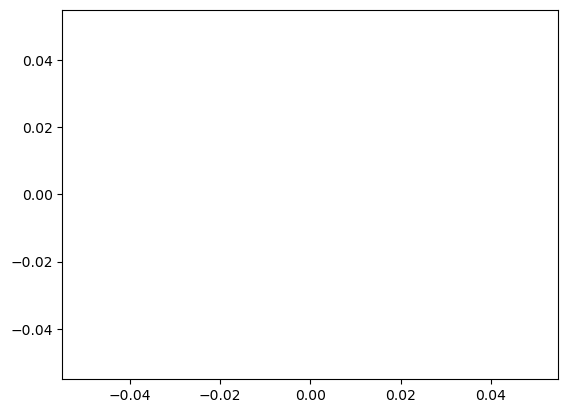

In [28]:
# Plotting the learning curve
import matplotlib.pyplot as plt

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = np.round(np.max(mean_rewards), 4)
arg_max_mean = np.argmax(mean_rewards)
baseline_fidelity = np.round(
    q_env.simulate_circuit(
        q_env.circuits[0],
        np.zeros((1, q_env.action_space.shape[-1])),
        update_env_history=False,
    ),
    4,
)[0]

plot_reward = True
plot_fidelity = True
plot_circuit_fidelity = False
plot_fidelity_nreps = False
plot_circuit_fidelity_nreps = False

if plot_reward:
    plt.plot(mean_rewards, label=f"Reward, max: {max_mean}")
if plot_fidelity:
    plt.plot(
        q_env.fidelity_history,
        label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
    )
if plot_circuit_fidelity_nreps:
    plt.plot(
        q_env.circuit_fidelity_history_nreps,
        label=f"Circuit Fidelity nreps(={q_env.n_reps})",
    )
if plot_fidelity_nreps:
    plt.plot(q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})")
if plot_circuit_fidelity:
    plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.axhline(
    baseline_fidelity,
    label=f"Baseline Fidelity ({baseline_fidelity})",
    color="red",
    linestyle="--",
)
plt.axhline(
    q_env.simulate_circuit(
        q_env.circuits[0], np.array([q_env.optimal_action]), update_env_history=False
    ),
    label=f"Optimal Fidelity = {q_env.fidelity_history[arg_max_mean]}(by max reward, reached at step {arg_max_mean})",
    color="green",
    linestyle="--",
)
plt.axhline(
    np.max(q_env.fidelity_history),
    label=f"Max Avg Fidelity ={np.max(q_env.fidelity_history)}(reached at step {np.argmax(q_env.fidelity_history)})",
    color="purple",
    linestyle="--",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env.config.backend.name if q_env.config.backend is not None else 'No backend'}"
)
plt.ylim(0.85, 1.00001)
plt.yscale("log")
plt.legend()

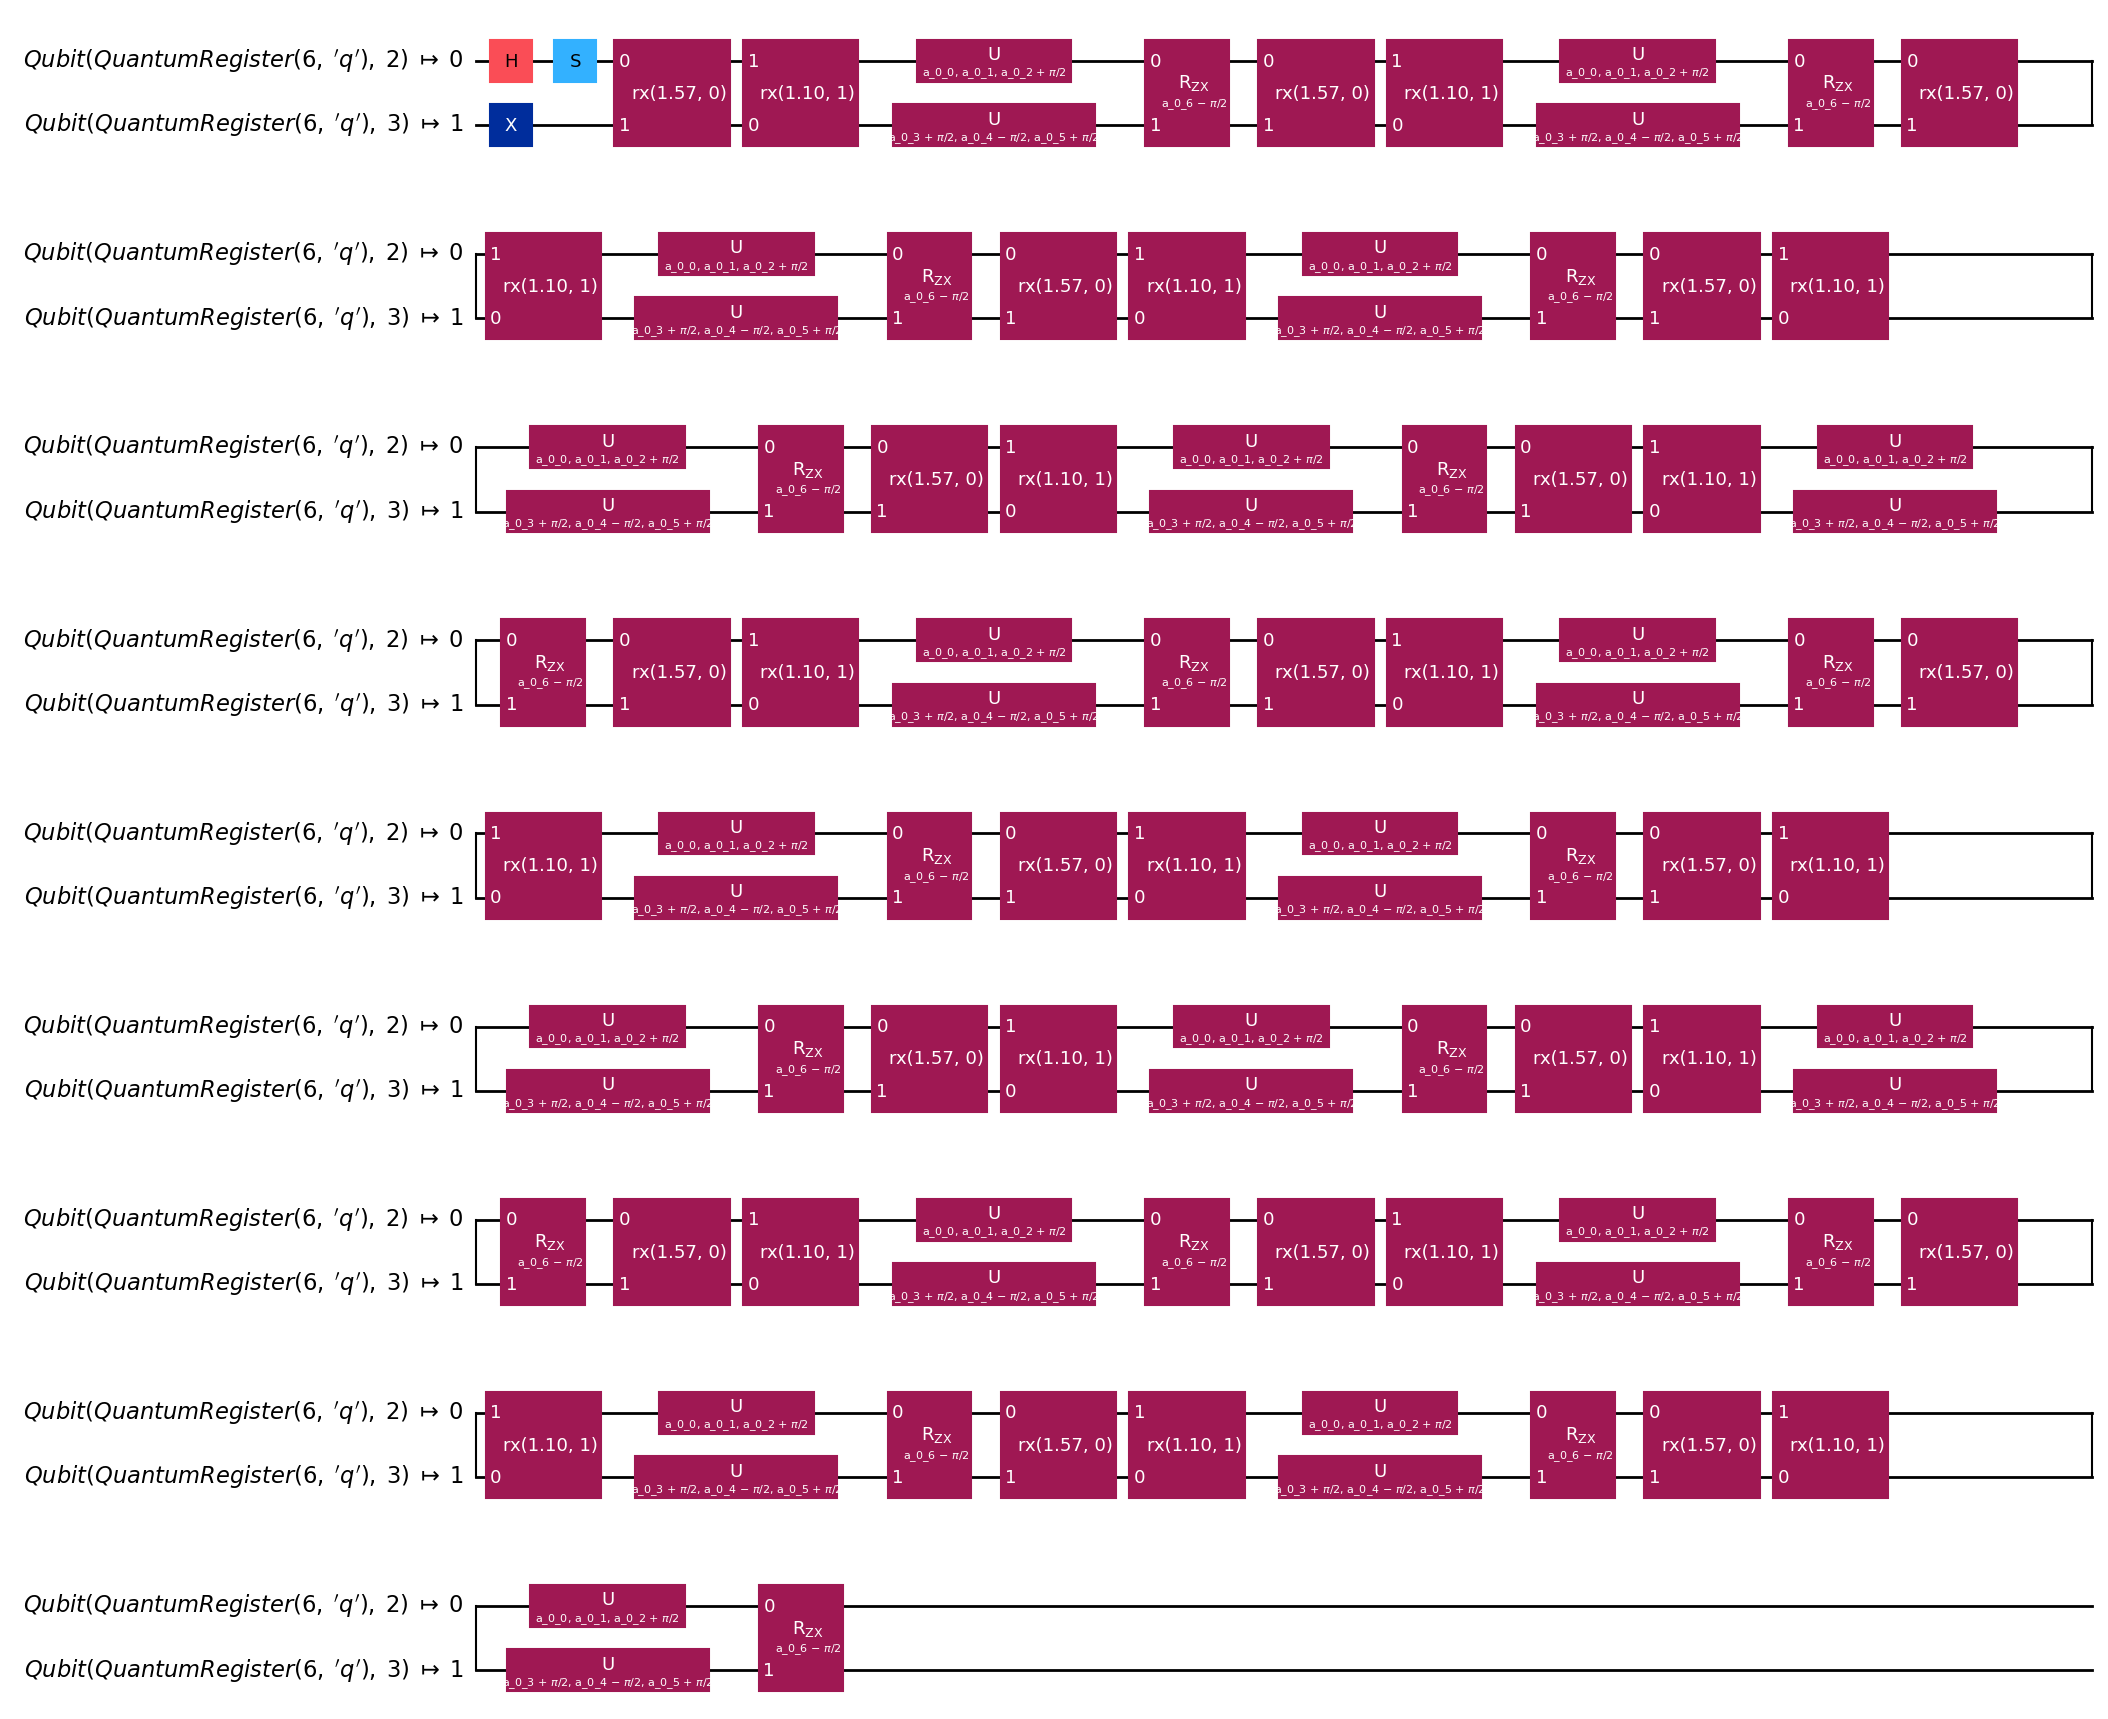

In [56]:
from qiskit.qasm3 import dumps as qasm3_dumps

circuit = q_env.pubs[6].circuit
circuit.draw("mpl")

In [57]:
print(qasm3_dumps(circuit))

OPENQASM 3.0;
include "stdgates.inc";
input float[64] a_0_0;
input float[64] a_0_1;
input float[64] a_0_2;
input float[64] a_0_3;
input float[64] a_0_4;
input float[64] a_0_5;
input float[64] a_0_6;
gate unitary _gate_q_0, _gate_q_1 {
  U(1.5711097381775212, -pi/2, pi/2) _gate_q_0;
  U(0, pi/2, -pi/2) _gate_q_1;
}
gate unitary_0 _gate_q_0, _gate_q_1 {
  U(1.096076292726302, -pi/2, pi/2) _gate_q_0;
  U(0, -pi, -pi) _gate_q_1;
}
gate rzx(p0) _gate_q_0, _gate_q_1 {
  h _gate_q_1;
  cx _gate_q_0, _gate_q_1;
  rz(p0) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
  h _gate_q_1;
}
gate unitary_1 _gate_q_0, _gate_q_1 {
  U(1.096076292726302, -pi/2, pi/2) _gate_q_0;
  U(0, -pi, -pi) _gate_q_1;
}
gate unitary_2 _gate_q_0, _gate_q_1 {
  U(1.096076292726302, -pi/2, pi/2) _gate_q_0;
  U(0, -pi, -pi) _gate_q_1;
}
gate unitary_3 _gate_q_0, _gate_q_1 {
  U(1.096076292726302, -pi/2, pi/2) _gate_q_0;
  U(0, -pi, -pi) _gate_q_1;
}
gate unitary_4 _gate_q_0, _gate_q_1 {
  U(1.096076292726302, -pi/2, pi/2) _gate_q_

In [45]:
q_env._pauli_shots

In [46]:
len(np.nonzero(np.round(q_env.target.Chi, 5))[0])

TypeError: unsupported operand type(s) for *: 'method' and 'float'

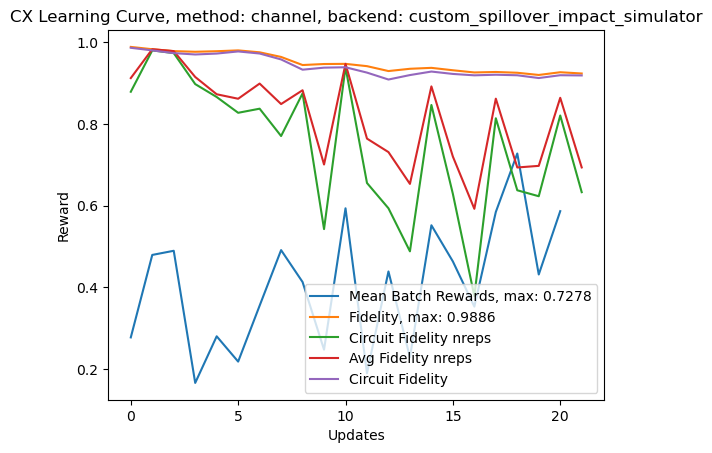

In [24]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

In [25]:
q_env.optimal_action

array([-0.49803594,  0.24635266, -0.3534245 , -0.47022524, -0.12757206,
       -0.0193499 , -0.22986718], dtype=float32)

In [119]:
sum(q_env.total_shots)

1874235.0797442582

In [27]:
q_env.backend.operation_names

['reset',
 'delay',
 'kraus',
 'rx',
 'qerror_loc',
 'save_unitary',
 'set_stabilizer',
 'ry',
 'set_statevector',
 'save_statevector',
 'save_probabilities_dict',
 'save_statevector_dict',
 'x',
 'for_loop',
 'if_else',
 'save_amplitudes_sq',
 'save_expval',
 'save_probabilities',
 'quantum_channel',
 'measure',
 'save_density_matrix',
 'switch_case',
 's',
 'z',
 'while_loop',
 'u',
 'unitary',
 'rzx',
 'save_superop',
 'rz',
 'set_unitary',
 'save_matrix_product_state',
 'save_clifford',
 'save_expval_var',
 'set_density_matrix',
 'initialize',
 'save_amplitudes',
 'set_matrix_product_state',
 'superop',
 'save_stabilizer',
 'cx',
 'h',
 'save_state',
 'break_loop',
 'set_superop',
 'roerror',
 'continue_loop']

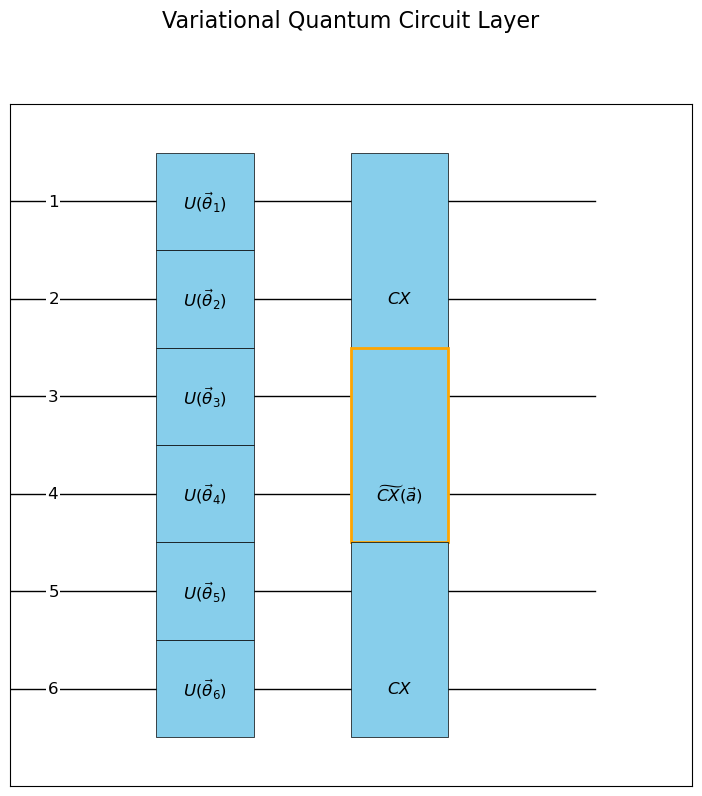

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pylatexenc
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

# Constants for drawing
BOX_WIDTH = 1
BOX_HEIGHT = 2  # Double the height for CX
WIRE_SPACING = 1
FONT_SIZE = 12
GAMMA_OFFSET = 0.3


def draw_circuit():
    """Draws the quantum circuit based on the given image."""

    num_qubits = 6
    qc = QuantumCircuit(num_qubits)  # Initialize Quantum Circuit

    fig, ax = plt.subplots(figsize=(10, 8))

    # Set axis limits and remove ticks
    ax.set_xlim(-1, 6)
    ax.set_ylim(-1, num_qubits)  # Original limits
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

    # Draw horizontal lines (qubit wires)
    for i in range(num_qubits):
        ax.plot([-1, 5], [num_qubits - 1 - i, num_qubits - 1 - i], "k-", linewidth=1)

    # Add qubit labels (Numbers 1-6)
    qubit_labels = [str(i + 1) for i in range(num_qubits)]  # Names of qubits
    for i, label in enumerate(qubit_labels):
        ax.text(
            -0.5,
            num_qubits - 1 - i,
            f"${label}$",
            ha="right",
            va="center",
            fontsize=FONT_SIZE,
            bbox=dict(facecolor="white", edgecolor="none", pad=1),
        )  # White box

    # Draw U gates with updated indices
    for i in range(num_qubits):
        x_pos = 1  # X position of gates.
        box = plt.Rectangle(
            (
                x_pos - BOX_WIDTH / 2,
                num_qubits - 1 - i - 0.5,
            ),  # Centered properly with BOX_HEIGHT=1
            BOX_WIDTH,
            1,  # Height =1 for these boxes
            facecolor="skyblue",
            edgecolor="black",
            linewidth=0.5,
            zorder=2,
        )
        ax.add_patch(box)
        ax.text(
            x_pos,
            num_qubits - 1 - i,
            f"$U({{\\vec{{\\theta}}_{i+1}}})$",
            ha="center",
            va="center",
            fontsize=FONT_SIZE,
        )

    # CX gates (shifted down)
    cx_positions = [1, 3, 5]  # Positions of the *top* qubits for CX gates
    x_pos = 3
    for i in range(len(cx_positions)):  # Each gate now takes two qubits
        if i == 0 or i == 2:
            box = plt.Rectangle(
                (
                    x_pos - BOX_WIDTH / 2,
                    num_qubits - 2 - cx_positions[i] + 0.5,
                ),  # Shifted Down
                BOX_WIDTH,
                2,
                facecolor="skyblue",
                edgecolor="black",
                linewidth=0.5,
                zorder=2,
            )
            ax.add_patch(box)
            ax.text(
                x_pos,
                num_qubits - 1 - cx_positions[i],
                "$CX$",
                ha="center",
                va="center",
                fontsize=FONT_SIZE,
            )
        else:
            # Tilde CX(a) gate
            box_a = plt.Rectangle(
                (
                    x_pos - BOX_WIDTH / 2,
                    num_qubits - 2 - cx_positions[i] + 0.5,
                ),  # Shifted Down
                BOX_WIDTH,
                2,
                facecolor="skyblue",
                edgecolor="orange",
                linewidth=2,
                zorder=2,
            )
            ax.add_patch(box_a)
            ax.text(
                x_pos,
                num_qubits - 1 - cx_positions[i],
                "$\\widetilde{CX}(\\vec{a})$",
                ha="center",
                va="center",
                fontsize=FONT_SIZE,
            )

    # # Draw Gamma arrows
    # start_gate_positions = [0, 1, 2, 3, 4]  # Index of the gates from where the gammas come
    # gamma_offsets = [0.5, 0.5, 0.6, 0.6, 0.5]
    # for i in range(len(start_gate_positions)):
    #     #  Adjust the arrows with an offset to display the interaction between lines
    #     gamma_start = (1 + gamma_offsets[i] * ((-1) ** i) * 0.05, num_qubits - 1 - start_gate_positions[i])  # Gate position (before)
    #     gamma_end = (1 + gamma_offsets[i] * ((-1) ** i) * 0.05, num_qubits - 2 - start_gate_positions[i])  # Go to next qubit
    #     if i == 0:
    #         gamma_name = "$\\gamma_{0 \\rightarrow 1}$"
    #         arrow_midpoint = (
    #             gamma_start[0],
    #             (gamma_start[1] + gamma_end[1]) / 2 - 0.1,
    #         )  # Move label to the arrow mid point
    #         ax.annotate(
    #             gamma_name,
    #             xy=gamma_end,
    #             xytext=arrow_midpoint,
    #             arrowprops=dict(arrowstyle="->", color="red", connectionstyle="arc3,rad=0.2"),
    #             fontsize=10,
    #             ha="center",
    #             va="bottom",
    #             xycoords="data",
    #             textcoords="data",
    #         )
    #     elif i == 1:
    #         gamma_name = "$\\gamma_{1 \\rightarrow 2}$"
    #         arrow_midpoint = (
    #             gamma_start[0],
    #             (gamma_start[1] + gamma_end[1]) / 2 - 0.1,
    #         )  # Move label to the arrow mid point
    #         ax.annotate(
    #             gamma_name,
    #             xy=gamma_end,
    #             xytext=arrow_midpoint,
    #             arrowprops=dict(arrowstyle="->", color="red", connectionstyle="arc3,rad=0.2"),
    #             fontsize=10,
    #             ha="center",
    #             va="bottom",
    #             xycoords="data",
    #             textcoords="data",
    #         )
    #     elif i == 2:
    #         # Split in two gammas
    #         # First gamma
    #         gamma_name = "$\\gamma_{2 \\rightarrow 3}$"
    #         arrow_midpoint = (
    #             gamma_start[0],
    #             (gamma_start[1] + gamma_end[1]) / 2 - 0.1,
    #         )  # Move label to the arrow mid point
    #         ax.annotate(
    #             gamma_name,
    #             xy=gamma_end,
    #             xytext=arrow_midpoint,
    #             arrowprops=dict(arrowstyle="->", color="red", connectionstyle="arc3,rad=0.2"),
    #             fontsize=10,
    #             ha="center",
    #             va="bottom",
    #             xycoords="data",
    #             textcoords="data",
    #         )
    #         # Second gamma
    #         gamma_name = "$\\gamma_{3 \\leftarrow 2}$"
    #         arrow_midpoint = (
    #             gamma_start[0],
    #             (gamma_start[1] + gamma_end[1]) / 2 - 0.1,
    #         )  # Move label to the arrow mid point
    #
    #         gamma_start = (1 + gamma_offsets[i] * ((-1) ** i) * 0.05, num_qubits - 1 - start_gate_positions[i])  # Gate position (before)
    #         gamma_end = (1 + gamma_offsets[i] * ((-1) ** i) * 0.05, num_qubits - 0 - start_gate_positions[i])  # Go to previous qubit
    #
    #         ax.annotate(
    #             gamma_name,
    #             xy=gamma_end,
    #             xytext=arrow_midpoint,
    #             arrowprops=dict(arrowstyle="->", color="red", connectionstyle="arc3,rad=-0.2"),
    #             fontsize=10,
    #             ha="center",
    #             va="top",
    #             xycoords="data",
    #             textcoords="data",
    #         )
    #     elif i == 3:
    #         gamma_name = "$\\gamma_{4 \\leftarrow 3}$"
    #         arrow_midpoint = (
    #             gamma_start[0],
    #             (gamma_start[1] + gamma_end[1]) / 2 - 0.1,
    #         )  # Move label to the arrow mid point
    #
    #         ax.annotate(
    #             gamma_name,
    #             xy=gamma_end,
    #             xytext=arrow_midpoint,
    #             arrowprops=dict(arrowstyle="->", color="red", connectionstyle="arc3,rad=-0.2"),
    #             fontsize=10,
    #             ha="center",
    #             va="top",
    #             xycoords="data",
    #             textcoords="data",
    #         )
    #     elif i == 4:
    #         gamma_name = "$\\gamma_{5 \\rightarrow 4}$"
    #         arrow_midpoint = (
    #             gamma_start[0],
    #             (gamma_start[1] + gamma_end[1]) / 2 - 0.1,
    #         )  # Move label to the arrow mid point
    #         ax.annotate(
    #             gamma_name,
    #             xy=gamma_end,
    #             xytext=arrow_midpoint,
    #             arrowprops=dict(arrowstyle="->", color="red", connectionstyle="arc3,rad=0.2"),
    #             fontsize=10,
    #             ha="center",
    #             va="bottom",
    #             xycoords="data",
    #             textcoords="data",
    #         )

    plt.title("Variational Quantum Circuit Layer", fontsize=16, y=1.1)  # Adjusted title position
    plt.tight_layout()

    return fig


# Draw the circuit and show it.
fig = draw_circuit()
plt.show()